In [1]:
import torch
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version reported by torch:", torch.version.cuda)
print("Device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Device 0:", torch.cuda.get_device_name(0))

Torch: 2.6.0+cu124
CUDA available: True
CUDA version reported by torch: 12.4
Device count: 1
Device 0: NVIDIA GeForce RTX 4070 Laptop GPU


In [2]:
from tqdm import tqdm

import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(8)
        self.conv4 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.softmax(self.fc2(x), dim=1)
        return x

def train_cnn(model, dataloader, criterion, optimizer, device, num_epochs=10):
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        progress_bar = tqdm(dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            progress_bar.set_postfix(loss=running_loss/(progress_bar.n+1))
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")


    




Classes: ['bernese_mountain_dog', 'border_collie', 'chihuahua', 'golden_retriever', 'labrador', 'pug', 'siberian_husky']
Classes: ['bernese_mountain_dog', 'border_collie', 'chihuahua', 'golden_retriever', 'labrador', 'pug', 'siberian_husky']


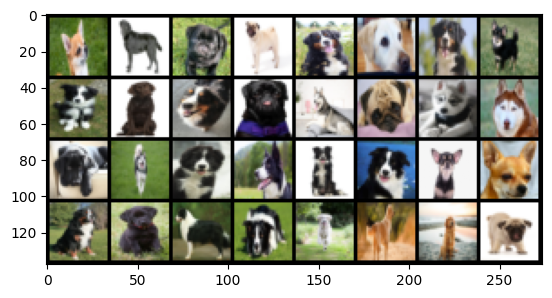

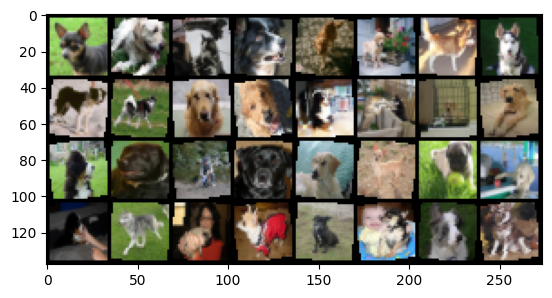

In [3]:
# Test loader is dog-breed-images
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader

test_set_path = "dog-breed-images/"
train_set_path = "stanford-dogs-dataset/images/"

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])
test_dataset = datasets.ImageFolder(root=test_set_path, transform=transform)
# print class names
print("Classes:", test_dataset.classes)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Train loader is standford-dogs-dataset
train_dataset = datasets.ImageFolder(root=train_set_path, transform=transform)
print("Classes:", train_dataset.classes) # print class names

# apply data augmentation to train dataset
train_dataset.transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


# visualize a batch of images
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# visualize a batch of test data
test_images, test_labels = next(iter(test_loader))
imshow(utils.make_grid(test_images))

# visualize a batch of train data
train_images, train_labels = next(iter(train_loader))
imshow(utils.make_grid(train_images))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [7]:
# Define criterion and optimizer
model = SimpleCNN(num_classes=len(train_dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
train_cnn(model, train_loader, criterion, optimizer, device, num_epochs=epochs)

# Test the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Test Accuracy: {100 * correct / total:.2f}%')


Epoch [1/50], Loss: 1.9447


Epoch [2/50], Loss: 1.9250


Epoch [3/50], Loss: 1.8779


Epoch [4/50], Loss: 1.8555


Epoch [5/50], Loss: 1.8456


Epoch [6/50], Loss: 1.8325


Epoch [7/50], Loss: 1.8180


Epoch [8/50], Loss: 1.8254


Epoch [9/50], Loss: 1.8176


Epoch [10/50], Loss: 1.8038


Epoch [11/50], Loss: 1.8020


Epoch [12/50], Loss: 1.8003


Epoch [13/50], Loss: 1.7962


Epoch [14/50], Loss: 1.7987


Epoch [15/50], Loss: 1.7984


Epoch [16/50], Loss: 1.7852


Epoch [17/50], Loss: 1.7832


Epoch [18/50], Loss: 1.7812


Epoch [19/50], Loss: 1.7878


Epoch [20/50], Loss: 1.7728


Epoch [21/50], Loss: 1.7826


Epoch [22/50], Loss: 1.7796


Epoch [23/50], Loss: 1.7824


Epoch [24/50], Loss: 1.7821


Epoch [25/50], Loss: 1.7655


Epoch [26/50], Loss: 1.7728


Epoch [27/50], Loss: 1.7602


Epoch [28/50], Loss: 1.7856


Epoch [29/50], Loss: 1.7686


Epoch [30/50], Loss: 1.7656


Epoch [31/50], Loss: 1.7584


Epoch [32/50], Loss: 1.7705


Epoch [33/50], Loss: 1.7512


Epoch [34/50], Loss: 1.7548


Epoch [35/50], Loss: 1.7492


Epoch [36/50], Loss: 1.7600


Epoch [37/50], Loss: 1.7542


Epoch [38/50], Loss: 1.7547


Epoch [39/50], Loss: 1.7574


Epoch [40/50], Loss: 1.7498


Epoch [41/50], Loss: 1.7504


Epoch [42/50], Loss: 1.7487


Epoch [43/50], Loss: 1.7360


Epoch [44/50], Loss: 1.7404


Epoch [45/50], Loss: 1.7477


Epoch [46/50], Loss: 1.7405


Epoch [47/50], Loss: 1.7484


Epoch [48/50], Loss: 1.7350


Epoch [49/50], Loss: 1.7383


Epoch [50/50], Loss: 1.7276
Test Accuracy: 41.02%


## Part 2 Task I

To compare the two datasets, first visualize a few sample images from each. Observe aspects such as image resolution, background complexity, dog pose, and annotation quality. Systematic differences may include:

- **Stanford Dogs Dataset**: Typically features higher-resolution images, varied backgrounds, and dogs in natural settings. Images may have more challenging backgrounds and diverse poses.
- **Dog Breed Images Dataset**: May contain more standardized images, sometimes with simpler backgrounds or studio-like settings. The annotation style and cropping may differ.

Briefly document any consistent differences you notice, as these can impact model training and generalization.